### Changing to the main directory

In [1]:
%cd ..

/home/isham/Desktop/machine-learning-projects/misc_ai_projects/elec-device-feedback-classification


/home/isham/anaconda3/envs/synthetic_dataset/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Importing Necessary Libraries

In [2]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value, DatasetInfo

### Loading the Dataset

We will be loading the dataset that has been created by synthetic data generator and model was used llama3.1:8b via ollama by Argilla team and is pushed to hugging face hub `disham993/ElectricalDeviceFeedback`.

In [3]:
datasets = load_dataset("disham993/ElectricalDeviceFeedback")

In [4]:
labels = datasets['train'].features['label'].names
labels

['negative', 'positive', 'mixed', 'neutral']

In [5]:
datasets['train'].description

''

In [6]:
df = datasets['train'].to_pandas()

In [7]:
df

,text,label
0,"The inverter's performance was satisfactory, y...",2
1,The smart meter's ability to provide real-time...,1
2,The inverter's efficiency loss under heavy loa...,0
3,The inverter's power factor correction algorit...,1
4,The circuit breaker's tripping mechanism exhib...,3
...,...,...
9006,I'm extremely disappointed with my smart meter...,0
9007,I recently installed a new solar panel system ...,0
9008,The circuit breaker's intermittent tripping ph...,3
9009,The novel harmonic distortion analysis on our ...,1


In [8]:
print(f"Training Class Distribution: {pd.Series(df['label']).value_counts()}\n")

Training Class Distribution: label
0    4252
1    3818
3     712
2     229
Name: count, dtype: int64



It is an imbalanced dataset. Therefore we cannot train the model using this dataset as there will be biasness. Lets take the necessary steps to overcome this.

### Train Test Validation Split

This step is crucial to avoid data leakage before generating new data points for labels 3 and 2.

In [10]:
X = df['text']
y = df['label']

# Initial split into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42  # 70% train, 30% temp
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42  # 15% test, 15% validation
)

Note: Stratification is crucial in splitting datasets, especially in classification problems, to ensure that the class proportions are preserved in each split (train, test, and validation). 

In [11]:
print(f"Training Class Distribution: {pd.Series(y_train).value_counts()}\n")
print(f"Validation Class Distribution: {pd.Series(y_val).value_counts()}\n")
print(f"Test Class Distribution: {pd.Series(y_test).value_counts()}")

Training Class Distribution: label
0    2976
1    2672
3     499
2     160
Name: count, dtype: int64

Validation Class Distribution: label
0    638
1    573
3    107
2     34
Name: count, dtype: int64

Test Class Distribution: label
0    638
1    573
3    106
2     35
Name: count, dtype: int64


### Handling Imbalance Dataset

Since you want to focus on generating neutral and mixed samples to balance the dataset, we will generate:

- neutral: 2270 
- mixed: 2983 

To do this, we have used additional script `generate_additional_data.py`. We are using `llama3.1` and prompt engineering to upsample the dataset.

In [12]:
generated_data = pd.read_csv("additional_feedback.csv")

In [24]:
generated_data['label'] = generated_data['label_name'].map({"mixed": 2, "neutral": 3})

In [27]:
def clean_text(text):
    text = text.split('\n')
    text = text[-1].strip().replace('"', '')
    return text

In [28]:
generated_data.isna().sum()

feedback      0
label_name    0
label         0
dtype: int64

In [29]:
generated_data['feedback'] = generated_data['feedback'].apply(clean_text)
generated_data['text'] = generated_data['feedback'] 
generated_data.drop(columns=['feedback'], inplace=True)
generated_data = generated_data.sample(frac=1, random_state=42)
generated_data.reset_index(drop=True, inplace=True)

In [30]:
generated_data.isna().sum()

label_name    0
label         0
text          0
dtype: int64

In [37]:
generated_data.iloc[2]

label_name                                              neutral
label                                                         3
text          This feedback example is purely factual and ob...
Name: 2, dtype: object

In [45]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train['label_name'] = df_train['label'].map({0: 'negative', 1: 'positive', 2: 'mixed', 3: 'neutral'})
df_train

,text,label,label_name
1781,While I appreciate the efficiency of my new sm...,0,negative
8461,The aberrant harmonics introduced by the inver...,0,negative
1187,The transformer's primary winding has some sig...,0,negative
3807,I recently purchased a 20A smart plug for my h...,1,positive
7006,I've been using this circuit breaker for month...,0,negative
...,...,...,...
6373,The circuit breaker's Arc Fault Detection feat...,1,positive
1013,The new smart meter installed in my home has b...,1,positive
4874,The smart meter's ability to provide real-time...,0,negative
4458,The new smart meter installed by our energy pr...,1,positive


In [51]:
df_train['label_name'].value_counts()

label_name
negative    2976
positive    2672
neutral      499
mixed        160
Name: count, dtype: int64

In [52]:
generated_data['label_name'].value_counts()

label_name
mixed      2983
neutral    2270
Name: count, dtype: int64

In [46]:
df_combined = pd.concat([df_train, generated_data], ignore_index=True)

In [47]:
df_combined['text'].isna().sum()

np.int64(0)

<Axes: title={'center': 'Label Distribution'}, ylabel='label_name'>

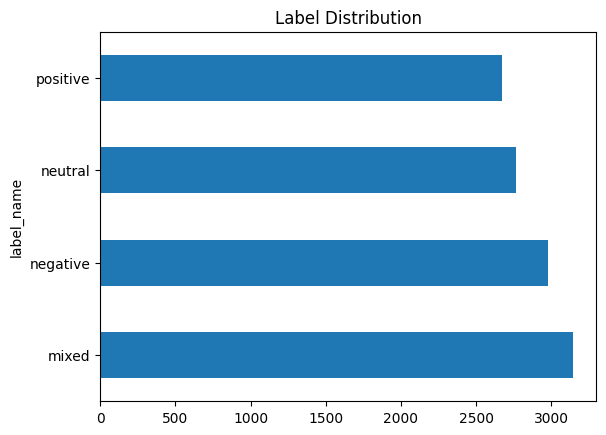

In [50]:
df_combined['label_name'].value_counts().plot(kind='barh', title='Label Distribution')

In [54]:
df_combined['label_name'].value_counts()

label_name
mixed       3143
negative    2976
neutral     2769
positive    2672
Name: count, dtype: int64

The distribution is much better now than the previous split, with:

- More balanced representation across all classes
- Ratio between highest (mixed: 3143) and lowest (positive: 2672) is about 1.18:1
- Each class has substantial samples (>2600)
- The distribution reflects a realistic mix of sentiments with no severely under-represented classes

### Removing Duplicates

In [55]:
# Check number of duplicates first
print("Number of duplicates:", df_combined.duplicated().sum())

# Drop duplicates and reset index
df_combined = df_combined.drop_duplicates().reset_index(drop=True)

# Verify the new shape
print("New shape after removing duplicates:", df_combined.shape)

# Check the new label distribution
print("\nNew label distribution:")
print(df_combined['label_name'].value_counts())

Number of duplicates: 8
New shape after removing duplicates: (11552, 3)

New label distribution:
label_name
mixed       3143
negative    2975
neutral     2762
positive    2672
Name: count, dtype: int64


In [58]:
df_combined.isna().sum()

text          0
label         0
label_name    0
dtype: int64

In [61]:
y_train_new = df_combined['label']

In [62]:
print(f"Training Class Distribution after generation of new data: {pd.Series(y_train_new).value_counts()}\n")
print(f"Validation Class Distribution: {pd.Series(y_val).value_counts()}\n")
print(f"Test Class Distribution: {pd.Series(y_test).value_counts()}")

Training Class Distribution: label
2    3143
0    2975
3    2762
1    2672
Name: count, dtype: int64

Validation Class Distribution: label
0    638
1    573
3    107
2     34
Name: count, dtype: int64

Test Class Distribution: label
0    638
1    573
3    106
2     35
Name: count, dtype: int64


In [69]:
df_combined.drop(columns=['label_name'], inplace=True)
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)
df_combined

,text,label
0,The incorporation of non-linear magneto-electr...,0
1,I recently installed a new smart meter in my h...,0
2,The circuit breaker's thermal-magnetic trip me...,0
3,The new smart meter installed at my house has ...,0
4,I've been using the 15A 6-outlet power strip f...,2
...,...,...
11547,* Demonstrating realistic technical observatio...,2
11548,I'm extremely disappointed with the performanc...,0
11549,The inverter's energy monitoring feature is us...,1
11550,The circuit breaker has exceeded its lifespan ...,0


### Converting Dataframe to Huggingface Dataset

Now that we are done with handling imbalance, we are converting the dataframe to huggingface dataset.

In [70]:
df_train = df_combined.copy()
df_val = pd.concat([X_val, y_val], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [101]:
# Define your labels
label_names = ['negative', 'positive', 'mixed', 'neutral']

# Add info about the dataset
description = """This dataset contains balanced feedback on electrical devices focusing on smart meters, solar panels, and circuit breakers. It extends the original Electrical Device Feedback dataset with additional data generated through Large Language Models (LLMs) and careful prompt engineering."""

# Define features consistently
features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=len(label_names), names=label_names)  # Not Sequence
})

# Create the dataset info with the same features
my_dataset_info = DatasetInfo(
    description=description,
    dataset_name="Electrical Device Feedback - Balanced Dataset",
    features=features  # Use the same features object
)

# Now create datasets
hf_dataset_train = Dataset.from_dict(
    {
        'text': df_train['text'].tolist(),
        'label': df_train['label'].tolist()
    },
    features=features,
    info=my_dataset_info
)

In [103]:
# Now create datasets
hf_dataset_validation = Dataset.from_dict(
    {
        'text': df_val['text'].tolist(),
        'label': df_val['label'].tolist()
    },
    features=features,
    info=my_dataset_info
)
hf_dataset_validation

Dataset({
    features: ['text', 'label'],
    num_rows: 1352
})

In [104]:
# Now create datasets
hf_dataset_test = Dataset.from_dict(
    {
        'text': df_test['text'].tolist(),
        'label': df_test['label'].tolist()
    },
    features=features,
    info=my_dataset_info
)
hf_dataset_test

Dataset({
    features: ['text', 'label'],
    num_rows: 1352
})

In [105]:
hf_dataset = DatasetDict({
    'train': hf_dataset_train,
    'test': hf_dataset_test,
    'validation': hf_dataset_validation
})

In [107]:
print(hf_dataset['train'].info)

DatasetInfo(description='This dataset contains balanced feedback on electrical devices focusing on smart meters, solar panels, and circuit breakers. It extends the original Electrical Device Feedback dataset with additional data generated through Large Language Models (LLMs) and careful prompt engineering.', citation='', homepage='', license='', features={'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'positive', 'mixed', 'neutral'], id=None)}, post_processed=None, supervised_keys=None, builder_name=None, dataset_name='Electrical Device Feedback - Balanced Dataset', config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)


In [108]:
import os

hf_dataset.push_to_hub(repo_id="disham993/ElectricalDeviceFeedbackBalanced", token=os.getenv("HF_TOKEN"))

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/disham993/ElectricalDeviceFeedbackBalanced/commit/2fbf5a23bd0d6ae52f5da4c53deef1a1e40aae19', commit_message='Upload dataset', commit_description='', oid='2fbf5a23bd0d6ae52f5da4c53deef1a1e40aae19', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/disham993/ElectricalDeviceFeedbackBalanced', endpoint='https://huggingface.co', repo_type='dataset', repo_id='disham993/ElectricalDeviceFeedbackBalanced'), pr_revision=None, pr_num=None)